## 启发式测试

In [ ]:
import time
from data import VCSPDataSet
from vcsp import VehicleCrewScheduling
from params import *

data_path = '../data/shift_50_01.csv'
data = VCSPDataSet(
    path=data_path,
)
VCSP_model = VehicleCrewScheduling()
VCSP_model.initialize(
    data,
    time_limit=600,
    pricing_strategy='BestEdges2',
    print_info=True
)
start = time.time()
VCSP_model.solve()
print('iteration:', VCSP_model.iteration)
print('num_driver:', VCSP_model.num_driver)
print('objval:', VCSP_model.objval)
print("CG_time:", time.time() - start)
VCSP_model.print_solution()


## DQN-Env测试

In [ ]:
import random
from itertools import count
import torch

from CGEnv import CGEnv
from params import *

random.seed(567)
n_actions = len(action_space)
env = CGEnv("cuda", config_test, action_space)
state = env.reset(run_mode='train')
for t in count():
    action = torch.tensor([random.randrange(n_actions)], device="cuda", dtype=torch.long)
    next_state, reward, done, info = env.step(action.item())
    print('ep:{}, t:{}, reward:{:.2f}, done:{}, objval:{:.2f}, heuristic:{}'.format(
        1, t + 1, reward, done, info['objval'], info['pricing_strategy'],
    ))
    if done:
        break

## 获取测试案例

In [1]:
import pandas as pd
import numpy as np

In [2]:
h1 = pd.read_csv("result/heuristc_test.csv")
# h1

In [3]:
h2 = pd.read_csv("result/heuristc_test_r2.csv")
# h2

In [4]:
h1 = h1[['instance', 'n']].drop_duplicates().values
h2 = h2[['instance', 'n']].drop_duplicates().values

In [5]:
print(len(h1), len(h2))

10 19


In [6]:
h = np.concatenate([h1, h2], axis=0)

In [7]:
# h

In [8]:
# np.save("../data/test_instances.npy", h)

## 结果测试

In [9]:
result = pd.DataFrame(columns=['instance', 'n', 'iter', 'objval'])

In [10]:
result.loc[len(result)] = [1,1,1,1]

In [11]:
result

,instance,n,iter,objval
0,1,1,1,1


In [12]:
test_instances = np.load("../data/test_instances.npy", allow_pickle=True)

In [14]:
len(test_instances)

29

## 合并启发式方法的结果

In [3]:
import pandas as pd

h1 = pd.read_csv("result/heuristic_ori.csv")
h2 = pd.read_csv("result/heuristic_add.csv")

In [8]:
h1 = h1[h1['method'] != 'BestEdges3']
h1.loc[h1['method'] == 'BestNodes', 'method'] = 'excat'
h1

,No.,instance,n,method,iters,objval,time
0,1,c208,28,BestEdges1,67,1450.3132,10.551422
1,1,c208,28,BestEdges2,127,993.3873,5.660862
3,1,c208,28,excat,52,1450.3132,33.381735
4,1,c208,28,Hyper,13,1245.7595,1.816167
5,2,c202,31,BestEdges1,1002,476.0060,93.140386
...,...,...,...,...,...,...,...
244,49,rc208,31,Hyper,4,2479.6858,599.491202
245,50,rc207,33,BestEdges1,49,2400.8878,49.632467
246,50,rc207,33,BestEdges2,70,2075.9260,67.252726
248,50,rc207,33,excat,44,2526.6523,303.087080


In [10]:
h = pd.concat([h1, h2]).sort_values(['No.', 'method'])
h.head(10)

,No.,instance,n,method,iters,objval,time
0,1,c208,28,BestEdges1,67,1450.3132,10.551422
1,1,c208,28,BestEdges2,127,993.3873,5.660862
0,1,c208,28,BestEdges3,72,1391.3514,6.814781
1,1,c208,28,BestNodes,108,1408.2438,15.223595
2,1,c208,28,BestPaths,91,1261.3643,33.674544
4,1,c208,28,Hyper,13,1245.7595,1.816167
3,1,c208,28,excat,52,1450.3132,33.381735
5,2,c202,31,BestEdges1,1002,476.0060,93.140386
6,2,c202,31,BestEdges2,627,404.6036,36.896697
3,2,c202,31,BestEdges3,1183,300.6880,134.168279


In [11]:
h.to_csv('result/heuristic.csv', index=False)

## PPT图片

[python基础 - networkx 绘图总结](https://blog.csdn.net/qq_19446965/article/details/106745837)

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# 设置matplotlib正常显示中文和负号
matplotlib.rcParams['font.sans-serif']=['SimHei']   # 用黑体显示中文
matplotlib.rcParams['axes.unicode_minus']=False     # 正常显示负号

### 约简定价网络

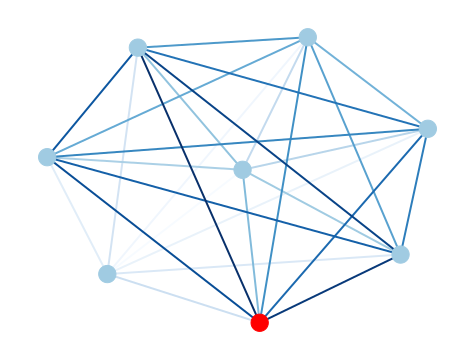

In [13]:
n = 8
G = nx.complete_graph(n)
pos = nx.spring_layout(G)  # 布局为中心放射状
edge_colors = range(len(G.edges()))
node_colors = ['#A0CBE2']*(n-1)
node_colors.append("red")
nx.draw(G, pos, node_color=node_colors, edge_color=edge_colors, width=2, edge_cmap=plt.cm.Blues, with_labels=False)
plt.show()

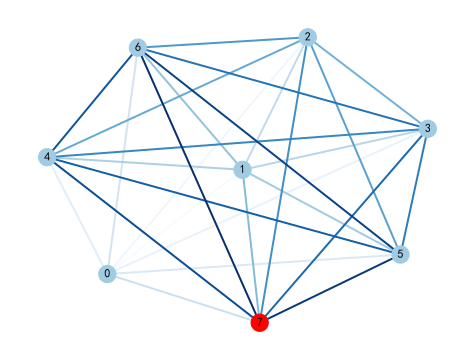

In [15]:
nx.draw(G, pos, node_color=node_colors, edge_color=edge_colors, width=2, edge_cmap=plt.cm.Blues, with_labels=True)
plt.show()

### 按照权值进行筛选

In [2]:
import random

In [10]:
n = 8
G = nx.complete_graph(n)
pos = nx.spring_layout(G)
node_colors = ['red']
node_colors.extend(['#A0CBE2']*(n-1))
random.seed(523)
for i, j in G.edges():
    weight = random.random()
    if i == 0 or j == 0:
        weight = min(1, weight + 0.3)
    G[i][j]['weight'] = weight

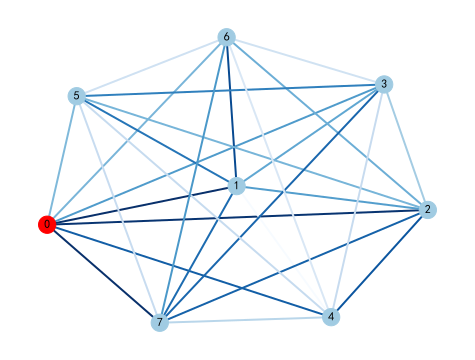

In [11]:
edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())
nx.draw(G, pos, node_color=node_colors, edge_color=weights, width=2, edge_cmap=plt.cm.Blues, with_labels=True)
plt.show()

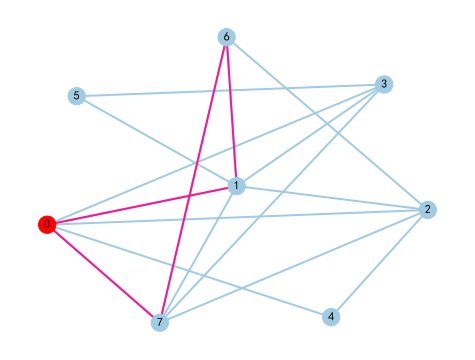

In [24]:
thres = 0.5
elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] > thres]
shortest_path = [(0,1), (1,6), (6,7), (7,0)]
edge_color = ['#A0CBE2'] * len(elarge) + ['#FF1493'] * len(shortest_path) 
nx.draw(G, pos, node_color=node_colors, edgelist=elarge + shortest_path, width=2, edge_color=edge_color, with_labels=True)
plt.show()

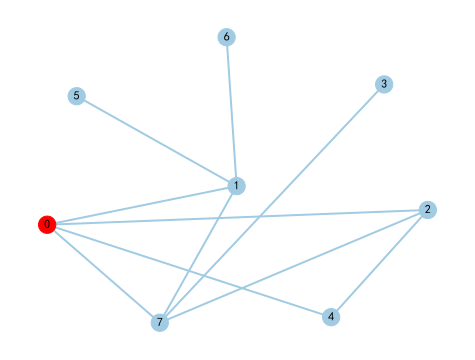

In [21]:
thres = 0.7
elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] > thres]
nx.draw(G, pos, node_color=node_colors, edgelist=elarge, width=2, edge_color='#A0CBE2', with_labels=True)
plt.show()

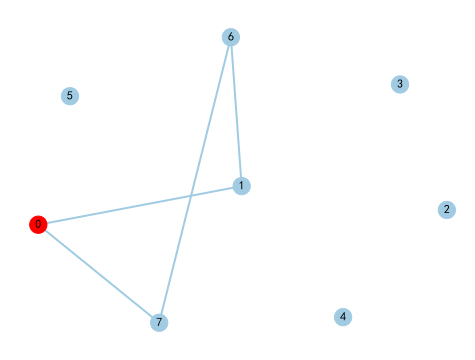

In [18]:
nx.draw(G, pos, node_color=node_colors, edgelist=shortest_path, width=2, edge_color='#A0CBE2', with_labels=True)
plt.show()

### Solomon数据集展示

In [54]:
from data import SolomonDataSet

In [77]:
instance_name = 'c101'
n = 25
data_path = f'../data/100/{instance_name}.txt'
data = SolomonDataSet(path=data_path, n_vertices=n)
G = data.G

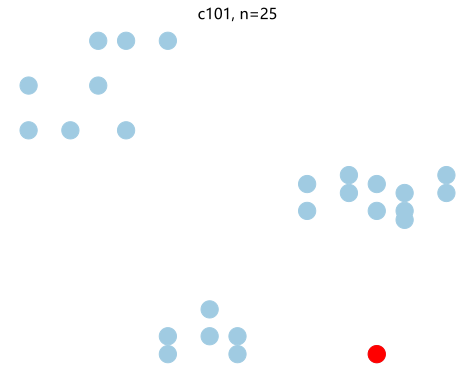

In [95]:
node_position = {v:(d['x'], d['y']) for (v, d) in G.nodes(data=True)}
node_colors = ['#A0CBE2']*(n+2)
node_colors[1] = 'red'
nx.draw(G, pos=node_position, node_color=node_colors, edgelist=[])
plt.rcParams.update({'font.size': 15})     #设置图例字体大小
plt.title(f"{instance_name}, n={n}", fontproperties="Microsoft YaHei")  # Times New Roman
plt.show()

In [134]:
def plot_node(instance_name, n, node_size=100, font_size=15):
    data_path = f'../data/100/{instance_name}.txt'
    data = SolomonDataSet(path=data_path, n_vertices=n)
    G = data.G
    node_position = {v:(d['x'], d['y']) for (v, d) in G.nodes(data=True)}
    node_colors = ['#A0CBE2']*(n+2)
    node_colors[1] = 'red'
    nx.draw(G, pos=node_position, node_color=node_colors, edgelist=[], node_size=node_size)
    plt.rcParams.update({'font.size': font_size})     #设置图例字体大小
    plt.title(f"{instance_name}, n={n}", fontproperties="Microsoft YaHei")  # Times New Roman
    plt.savefig(f"F:/Users/Documents/汇报/img/{instance_name}_{n}.png", bbox_inches="tight")
    plt.show()

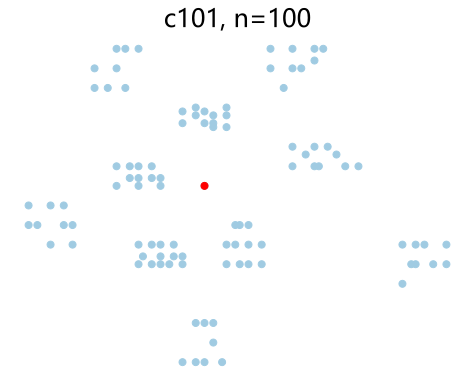

In [135]:
plot_node('c101', 100, node_size=50, font_size=25)

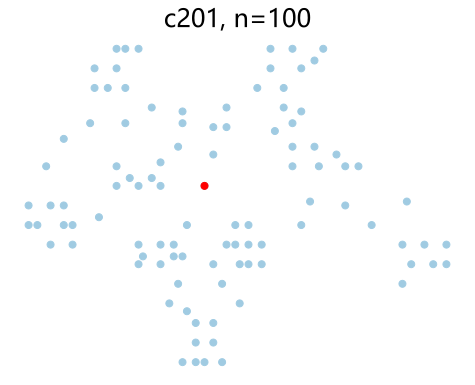

In [136]:
plot_node('c201', 100, node_size=50, font_size=25)

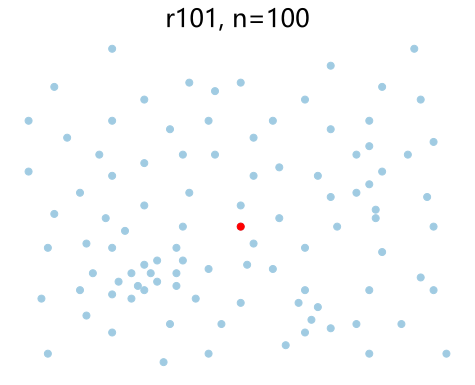

In [137]:
plot_node('r101', 100, node_size=50, font_size=25)

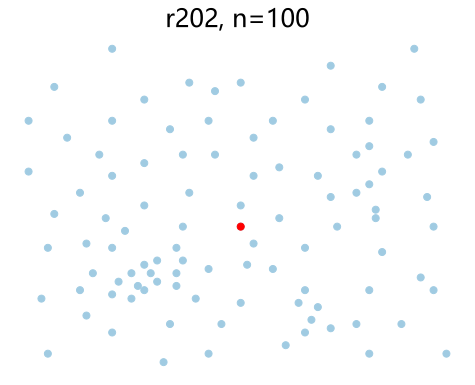

In [141]:
plot_node('r201', 100, node_size=50, font_size=25)

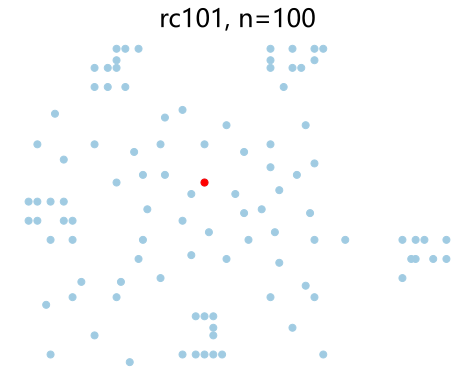

In [139]:
plot_node('rc101', 100, node_size=50, font_size=25)

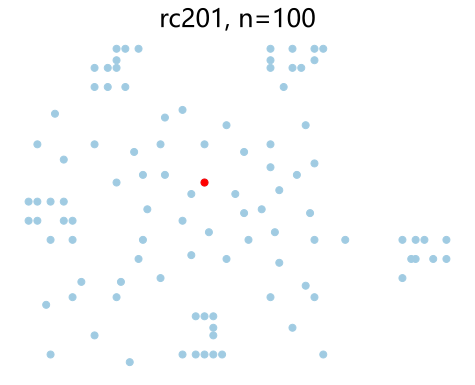

In [140]:
plot_node('rc201', 100, node_size=50, font_size=25)

### Solomon数据集规律

In [142]:
instance_name = 'c101'
n = 100
data_path = f'../data/100/{instance_name}.txt'
data = SolomonDataSet(path=data_path, n_vertices=n)
G = data.G

In [152]:
demand = [d['demand'] for (v,d) in list(G.nodes(data=True))[2:]]
tw_span = [d['tw_span'] for (v,d) in list(G.nodes(data=True))[2:]]

In [160]:
def get_node_featrue(instance_name, n):
    data_path = f'../data/100/{instance_name}.txt'
    data = SolomonDataSet(path=data_path, n_vertices=n)
    G = data.G
    demand = [d['demand'] for (v,d) in list(G.nodes(data=True))[2:]]
    tw_span = [d['tw_span'] for (v,d) in list(G.nodes(data=True))[2:]]
    return demand, tw_span

In [161]:
probNum = {
        'c1': 9, 'c2': 8,
        'r1': 12, 'r2': 11,
        'rc1': 8, 'rc2': 8,
    }
result = pd.DataFrame(columns=['class', 'type', 'instance', 'avg_demand', 'max_tw', 'min_tw', 'avg_tw'])
for prob_type in ['c1', 'c2', 'r1', 'r2', 'rc1', 'rc2']:
    for prob in range(probNum[prob_type]):
    # for prob in range(1): # for test
        instance_name = '{}{:02d}'.format(prob_type, prob + 1)
        demand, tw_span = get_node_featrue(instance_name, 100)
        result.loc[len(result)] = [prob_type[:-1], prob_type[-1], instance_name, sum(demand)/100, max(tw_span), min(tw_span), sum(tw_span)/100]


In [162]:
result

,class,type,instance,avg_demand,max_tw,min_tw,avg_tw
0,c,1,c101,18.10,89,37,60.76
1,c,1,c102,18.10,1135,43,325.69
2,c,1,c103,18.10,1136,43,588.49
3,c,1,c104,18.10,1136,43,852.94
4,c,1,c105,18.10,177,75,121.61
5,c,1,c106,18.10,387,29,156.15
6,c,1,c107,18.10,180,180,180.00
7,c,1,c108,18.10,353,149,243.28
8,c,1,c109,18.10,360,360,360.00
9,c,2,c201,18.10,160,160,160.00


In [163]:
_, tw1 = get_node_featrue('c201', 100)
_, tw2 = get_node_featrue('c202', 100)

In [165]:
max(tw1)

160

In [166]:
tw2

[3272,
 3279,
 3270,
 160,
 3284,
 160,
 3273,
 160,
 160,
 160,
 160,
 3261,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 3288,
 160,
 160,
 160,
 160,
 3265,
 160,
 160,
 160,
 160,
 3266,
 160,
 160,
 3267,
 160,
 160,
 3260,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 3289,
 160,
 3277,
 160,
 3278,
 160,
 160,
 160,
 160,
 160,
 160,
 3259,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 3276,
 160,
 160,
 3284,
 160,
 160,
 160,
 160,
 160,
 160,
 3264,
 3267,
 160,
 3253,
 160,
 160,
 160,
 160,
 160,
 3277,
 160,
 160,
 3259,
 3262,
 3275,
 160,
 3269,
 160,
 160]

### eps衰减

Text(0, 0.5, 'eps_threshold')

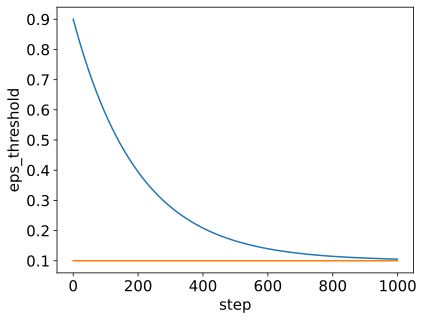

In [25]:
import math

EPS_END = 0.1
EPS_START = 0.9
EPS_DECAY = 200     # (0.9 - 0.05) * exp(-1.* 1000 / 200) = 0.005
x = list(range(1000))
eps_threshold = [EPS_END + (EPS_START - EPS_END) * math.exp(-1. * xi / EPS_DECAY) for xi in x]
plt.plot(x, eps_threshold)
plt.plot(x, [EPS_END]*1000)

fontsize = 15
plt.xticks(fontsize=fontsize) # ,rotation=90
plt.yticks(fontsize=fontsize)
plt.xlabel("step", fontsize=fontsize)
plt.ylabel("eps_threshold", fontsize=fontsize)
# plt.savefig("F:/Users/Documents/汇报/img/eps_threshold_0.1.png")

In [26]:
(0.9 - 0.05) * math.exp(-1.* 1000 / 200)

0.005727254949222647

### lr衰减

Text(0, 0.5, 'lr_decay')

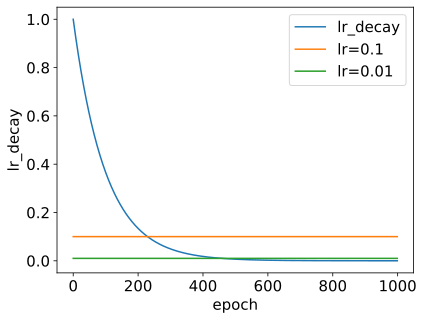

In [16]:
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

x = list(range(1000))
lr = 1
lr_decay = [lr * 0.99 ** xi for xi in x]
plt.plot(x, lr_decay, label=f"lr_decay")
plt.plot(x, [0.1]*1000, label="lr=0.1")
plt.plot(x, [0.01]*1000, label="lr=0.01")
fontsize = 15
plt.legend(fontsize=fontsize)
plt.xticks(fontsize=fontsize) # ,rotation=90
plt.yticks(fontsize=fontsize)
plt.xlabel("epoch", fontsize=fontsize)
plt.ylabel("lr_decay", fontsize=fontsize)
# plt.savefig("F:/Users/Documents/汇报/img/eps_threshold_0.1.png")

### gap_reward

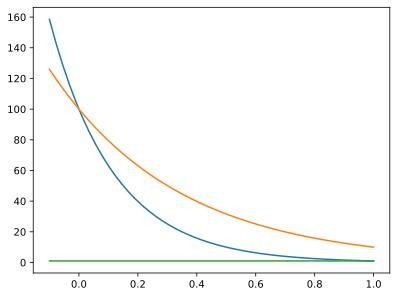

In [36]:
import numpy as np
gap = np.linspace(-0.1,1)
plt.plot(gap, [100**(1-g) for g in gap])
plt.plot(gap, [100 * 10**(-g) for g in gap])
plt.plot(gap, [1]*len(gap))
plt.show()

## 计算特征的均值和方差

In [2]:
import os
import pickle
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# 设置matplotlib正常显示中文和负号
# matplotlib.rcParams['font.sans-serif']=['SimHei']   # 用黑体显示中文
# matplotlib.rcParams['axes.unicode_minus']=False     # 正常显示负号

In [2]:
path = os.path.join('..', 'no_post_process')

In [4]:
with open(path + '/memory_a=100_e=0.05_g=0.95_lr=0.1_seed=523_06.44-11.28.pkl',"rb") as f:
    memory = pickle.load(f)

In [7]:
from collections import namedtuple, deque

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))
batch = Transition(*zip(*memory))

In [11]:
state = batch.state

In [22]:
import numpy as np

state_array = np.array([s.cpu().numpy() for s in state])

In [23]:
state_array.shape

(100000, 14)

In [34]:
state_array[10000]

array([0.954917  , 1.1277101 , 0.33333334, 0.13815789, 0.3329346 ,
       0.7358393 , 0.58611166, 0.6753589 , 0.6879298 , 0.67452073,
       0.33401698, 0.35626873, 0.31293154, 0.03773148], dtype=float32)

In [28]:
state_array.std(axis=0)

array([0.06044082, 0.20721085, 0.14330077, 0.2406444 , 0.05192028,
       0.01829603, 0.01080656, 0.00560187, 0.01209558, 0.00559653,
       0.02418068, 0.0264779 , 0.02734187, 0.00158831], dtype=float32)

In [29]:
state_array.mean(axis=0)

array([0.95413005, 1.4853836 , 0.19878565, 0.31273198, 0.3727517 ,
       0.7851811 , 0.59754086, 0.68442655, 0.69573   , 0.6840644 ,
       0.35038525, 0.37444982, 0.33625013, 0.03794398], dtype=float32)

In [35]:
state_mean = state_array.mean(axis=0)
state_std = state_array.std(axis=0)
norm_state = (state_array - state_mean) / state_std

In [37]:
norm_state.std(0)

array([1.0001413 , 1.0000025 , 0.99986446, 0.99990857, 1.0000013 ,
       0.9999984 , 0.999965  , 0.9999601 , 0.9999869 , 0.9999577 ,
       1.0000257 , 1.0000468 , 0.9999582 , 0.99996716], dtype=float32)

In [38]:
norm_state[100]

array([ 0.75892323,  1.4329327 , -1.3871918 , -1.2995607 , -0.80437416,
        1.0266699 , -0.997215  ,  0.13288468, -0.4363472 ,  0.1730777 ,
       -0.5671736 , -0.6151899 , -1.1542761 ,  1.3317168 ], dtype=float32)

### 多次测量取平均

In [39]:
file_list = [
    "memory_a=100_e=0.05_g=0.95_lr=0.1_seed=523_06.44-11.28.pkl",
    "memory_a=100_e=0.05_g=0.95_lr=0.01_seed=123_18.13-11.28.pkl",
    "memory_a=100_e=0.05_g=0.95_lr=0.01_seed=523_06.14-11.29.pkl"
]
state_mean_list = []
for file in file_list:
    with open(path + '/' + file, "rb") as f:
        memory = pickle.load(f)
    batch = Transition(*zip(*memory))
    state = batch.state
    state_array = np.array([s.cpu().numpy() for s in state])
    state_mean = state_array.mean(axis=0)
    print(state_mean)
    state_mean_list.append(state_mean)

[0.95413005 1.4853836  0.19878565 0.31273198 0.3727517  0.7851811
 0.59754086 0.68442655 0.69573    0.6840644  0.35038525 0.37444982
 0.33625013 0.03794398]
[0.95722693 1.4820637  0.19291174 0.30196476 0.36751524 0.78393376
 0.5974532  0.68461615 0.6951465  0.6842484  0.35157228 0.37572894
 0.33835757 0.03782194]
[0.96013206 1.3576344  0.18577375 0.2731778  0.35895392 0.7739369
 0.597235   0.6845961  0.69507563 0.6842113  0.35203764 0.37602556
 0.3376192  0.03789463]


In [41]:
state_mean_list[0]

array([0.95413005, 1.4853836 , 0.19878565, 0.31273198, 0.3727517 ,
       0.7851811 , 0.59754086, 0.68442655, 0.69573   , 0.6840644 ,
       0.35038525, 0.37444982, 0.33625013, 0.03794398], dtype=float32)

In [42]:
state_mean_list[1]

array([0.95722693, 1.4820637 , 0.19291174, 0.30196476, 0.36751524,
       0.78393376, 0.5974532 , 0.68461615, 0.6951465 , 0.6842484 ,
       0.35157228, 0.37572894, 0.33835757, 0.03782194], dtype=float32)

In [43]:
(state_mean_list[0] + state_mean_list[1]) / 2

array([0.95567846, 1.4837236 , 0.1958487 , 0.30734837, 0.37013346,
       0.78455746, 0.597497  , 0.6845213 , 0.69543827, 0.6841564 ,
       0.35097876, 0.37508938, 0.33730385, 0.03788296], dtype=float32)